 # I.	Problem statement
    
   Singular value decomposition (SVD) and Eigendecomposition are 2 popular methods of matrix decomposition, which reduces a matrix to lower-rank matrices to simplify more complex operations. Eigendecomposition decomposes a square matrix into a set of eigen values and eigen vectors. Eigenvectos and eigenvalues is important because they describe long-term behavior of the system. On the other hand, Singular value decomposition decomposes the matrix into singular values and singular vectors similar to Eigendecomposition, but SVD also works on non-square matrices which makes it more generally applicable.
    
   Eigendecomposition and SVD both have many important applications in the field of machine learning and data science, especially in dimensionality reduction to provide the fundamental characteristics of the data. Some real-life applications of SVD include image processing, data reduction, and recommendation systems; while eigendecomposition is important for spectral clustering as well as page-rank algorithms, etc.

   Some programming language provides built-in software packages to calculate the SVD and Eigendecomposition. For example, Python has `numpy.linalg`, `scipy.decomp_svd`, `sklearn.decomposition` libraries which svd function for SVD and `eig` for eigendecomposition. Since users can blindly apply these functions to decompose a matrix into eigenvalues and eigenvectors or singular values and singular vectors, many don’t really understand the steps it takes to compute the output from the input, and as the result apply the functions wrongly, misinterpret the output or fail to modify the function for more specific needs.  

   The motivation of this project is to understand how to calculate SVD as this will reinforce the fundamental understanding of linear algebra and linear transformation such as matrix stretching and rotating. Moreover, this will provide fundamental knowledge of other important concepts in machine learning such as principal component analysis (PCA), natural language processing, and computer vision etc.

# II. Introduction to Singular Value Decomposition (SVD)

   Singular Value Decomposition is a method in linear algebra to decompose a matrix (A) into 3 other matrices: $A = USV^T$. SVD performs several transformations of Matrix A: rotate the matrix by transposed of V, apply scale factor S, rotate the matrix by U. Unlike Eigendecomposition, SVD can work on non-square and sparse matrices.
   * A: `m x n` matrix to decompose
   * U: `m x m` or `m x k` [unitary matrix](https://en.wikipedia.org/wiki/Unitary_matrix), columns of U are left singular vectors of A
   * S: `m x n` matrix of s non-negative values on diagonal axis, s values of diagonal of Sigma are the **singular values** of A
   * VT: `n x n` or `k x n` transposed of a [unitary matrix](https://en.wikipedia.org/wiki/Unitary_matrix), columns of V are singular vectors of A
           

In [106]:
import numpy as np
from numpy import array
import numpy.linalg as linalg
from numpy.linalg import svd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from numpy.linalg import norm
from random import normalvariate
from math import sqrt
#import seaborn as sns

### Visualize SVD transformation

Unit circle:


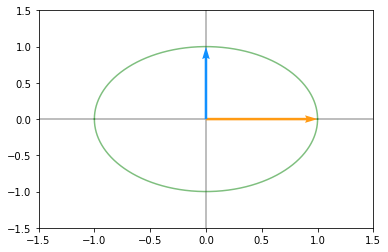

Unit circle transformed by A:


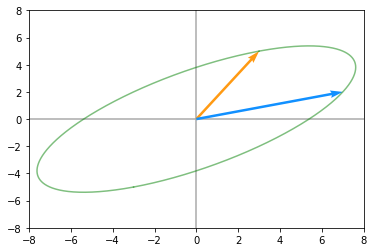

In [63]:
def plotVectors(vecs, cols, alpha=1):
    """
    Plot set of vectors.

    Parameters
    ----------
    vecs : array-like
        Coordinates of the vectors to plot. Each vectors is in an array. For
        instance: [[1, 3], [2, 2]] can be used to plot 2 vectors.
    cols : array-like
        Colors of the vectors. For instance: ['red', 'blue'] will display the
        first vector in red and the second in blue.
    alpha : float
        Opacity of vectors

    Returns:

    fig : instance of matplotlib.figure.Figure
        The figure of the vectors
    """
    plt.figure()
    plt.axvline(x=0, color='#A9A9A9', zorder=0)
    plt.axhline(y=0, color='#A9A9A9', zorder=0)

    for i in range(len(vecs)):
        x = np.concatenate([[0,0],vecs[i]])
        plt.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha)
        
def matrixToPlot(matrix, vectorsCol=['#FF9A13', '#1190FF']):
    """
    Modify the unit circle and basis vector by applying a matrix.
    Visualize the effect of the matrix in 2D.

    Parameters
    ----------
    matrix : array-like
        2D matrix to apply to the unit circle.
    vectorsCol : HEX color code
        Color of the basis vectors

    Returns:

    fig : instance of matplotlib.figure.Figure
        The figure containing modified unit circle and basis vectors.
    """
    # Unit circle
    x = np.linspace(-1, 1, 100000)
    y = np.sqrt(1-(x**2))

    # Modified unit circle (separate negative and positive parts)
    x1 = matrix[0,0]*x + matrix[0,1]*y
    y1 = matrix[1,0]*x + matrix[1,1]*y
    x1_neg = matrix[0,0]*x - matrix[0,1]*y
    y1_neg = matrix[1,0]*x - matrix[1,1]*y

    # Vectors
    u1 = [matrix[0,0],matrix[1,0]]
    v1 = [matrix[0,1],matrix[1,1]]

    plotVectors([u1, v1], cols=[vectorsCol[0], vectorsCol[1]])

    plt.plot(x1, y1, 'g', alpha=0.5)
    plt.plot(x1_neg, y1_neg, 'g', alpha=0.5)

A = np.array([[3, 7], [5, 2]])

print('Unit circle:')
matrixToPlot(np.array([[1, 0], [0, 1]]))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

print('Unit circle transformed by A:')
matrixToPlot(A)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

## 1. SVD math modelling

**Power Iteration algorithm**

Given a matrix `A`, compute the SVD of the matrix

* Step 1: Compute 
    * $A^T$
    * $A^TA$ = $(U\Sigma$$V^T)^T(U\Sigma$$V^T)$ = $V\Sigma^2V^T$

* Step 2: Calculate Eigenvalues and Singular values of $A^TA$ and sort them in descending order
    * Calculate f(c) = $A^TA$ - $cI$ = 0
    * Solve f(c) for eigenvalues -> $sqrt(eigenvalues)$ for singular values
    
* Step 3: Construct diagonal matrix **S** by placing singular values in descending order along itsdiagonal. Compute its inverse, $S^-1$

* Step 4: Use the ordered eigenvalues from step 2 and compute the eigenvectors of ATA. Place these eigenvectors along the columns of **V** and compute its transpose, $V^T$

* Step 5. Compute **U** as U = $AVS^I$. 

* Step 6: Compute the full SVD using A = $USV^T$ to complete the proof
    

In [129]:
def svd1d(A, epsilon=1e-10):
    ''' 
        This function calculates the one-dimensional SVD as the helper for manual_svd function 
        Returns:
        * 1 dimensional vector that is a dot product of ATA and a random unit vector
    '''
    n, m = A.shape
    unnormalized = [normalvariate(0, 1) for _ in range(min(n,m))]
    normalized = sqrt(sum(x * x for x in unnormalized))
    x = [x / normalized for x in unnormalized]
    lastV = None
    currentV = x
    
    ATA = np.dot(A.T, A) if n>m else np.dot(A, A.T)
    
    iterations = 0
    while True:
        iterations+=1
        lastV = currentV
        currentV = np.dot(ATA, lastV)
        currentV = currentV / norm(currentV)

        if abs(np.dot(currentV, lastV)) > 1 - epsilon:
            print(f'converged in {iterations} iterations')
            return currentV


def manual_svd(A, k=None, epsilon=1e-10):
    '''
        Compute the singular value decomposition of a matrix A
        using the power method. 
        Parameters:
        * A is the input matrix 
        * k is the number of singular values to compute. If k is None, this computes the full-rank decomposition.
        Returns: U, S, V
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdSoFar = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        #print(f'i={i}')
        matrixFor1D = A.copy()

        for singularValue, u, v in svdSoFar[:i]:
            matrixFor1D -= singularValue * np.outer(u, v)

        if n > m:
            v = svd1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(A, v)
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            v_unnormalized = np.dot(A.T, u)
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdSoFar.append((sigma, u, v))
        #print(matrixFor1D)
        #print(svdSoFar)

    S, U, V = [np.array(x) for x in zip(*svdSoFar)]
    return  U.T, S, V

In [132]:
%%time
print('\033[1m'+"*Test manual svd with Maxtrix*"+'\033[0m')
M = np.array([
        [2, 5, 3],
        [1, 2, 1],
        [4, 1, 1],
        [3, 5, 2],
        [5, 3, 1],
        [4, 5, 5],
        [2, 4, 2],
        [2, 2, 5],
    ], dtype='float64')
print(pd.DataFrame(M))
# SVD
U, S, V = manual_svd(M)
print('\033[1m'+f"U.shape {U.shape}, S.shape {S.shape}, V.shape {V.shape}"+'\033[0m')
print('U\n',pd.DataFrame(U))
print('S\n',S)
print('V\n',pd.DataFrame(V))

*Test manual svd with Maxtrix*
     0    1    2
0  2.0  5.0  3.0
1  1.0  2.0  1.0
2  4.0  1.0  1.0
3  3.0  5.0  2.0
4  5.0  3.0  1.0
5  4.0  5.0  5.0
6  2.0  4.0  2.0
7  2.0  2.0  5.0
converged in 6 iterations
converged in 25 iterations
converged in 2 iterations
U.shape (8, 3), S.shape (3,), V.shape (3, 3)
U
           0         1         2
0  0.394585 -0.239230 -0.354464
1  0.158302 -0.030547 -0.152998
2  0.221552  0.520857  0.393360
3  0.396926  0.086496 -0.410527
4  0.346302  0.641288  0.073842
5  0.533475 -0.191690  0.199489
6  0.316605 -0.061093 -0.305997
7  0.328402 -0.459711  0.623538
S
 [15.09626916  4.30056855  3.40701739]
V
           0         1         2
0  0.541848  0.670710  0.506507
1  0.751517 -0.116797 -0.649292
2  0.376328 -0.732466  0.567336
CPU times: user 9.41 ms, sys: 2.44 ms, total: 11.8 ms
Wall time: 9.61 ms


In [131]:
%%time
print('\033[1m'+"\n*Test SVD function in scipy.linalg with Matrix*"+'\033[0m')
# A simple illustration of SVD using scipy.linalg
M = np.array([
        [2, 5, 3],
        [1, 2, 1],
        [4, 1, 1],
        [3, 5, 2],
        [5, 3, 1],
        [4, 5, 5],
        [2, 4, 2],
        [2, 2, 5],
    ], dtype='float64')
print(pd.DataFrame(M))
# SVD
U, S, V = np.linalg.svd(M, full_matrices=False)
print('\033[1m'+f"U.shape {U.shape}, S.shape {S.shape}, V.shape {V.shape}"+'\033[0m')
print('U\n',pd.DataFrame(U))
print('S\n',S)
print('V\n',pd.DataFrame(V))



*Test SVD function in scipy.linalg with Matrix*
     0    1    2
0  2.0  5.0  3.0
1  1.0  2.0  1.0
2  4.0  1.0  1.0
3  3.0  5.0  2.0
4  5.0  3.0  1.0
5  4.0  5.0  5.0
6  2.0  4.0  2.0
7  2.0  2.0  5.0
U.shape (8, 3), S.shape (3,), V.shape (3, 3)
U
           0         1         2
0 -0.394585  0.239236 -0.354459
1 -0.158302  0.030549 -0.152998
2 -0.221552 -0.520861  0.393349
3 -0.396926 -0.086490 -0.410529
4 -0.346303 -0.641288  0.073829
5 -0.533474  0.191689  0.199493
6 -0.316605  0.061098 -0.305995
7 -0.328402  0.459704  0.623548
S
 [15.09626916  4.30056855  3.40701739]
V
           0         1         2
0 -0.541848 -0.670710 -0.506506
1 -0.751523  0.116809  0.649283
2  0.376316 -0.732464  0.567347
CPU times: user 7.88 ms, sys: 1.9 ms, total: 9.78 ms
Wall time: 8.1 ms


Even though U and V outputs are different between np.linalg.svd function and manually calculated SVD, we can see that the Singular Values S are the same
 **S (np.linalg.svd) = S (manual_svd) = [15.096269, 4.300569, 3.407017]**

Both functions are similar and provide expected result

## 2.  Application of SVD
   * Dimensionality reduction: Data with a large number of features, such as more features (columns) than observations (rows) may be reduced to a smaller subset of features that are most relevant to the prediction problem.
   * Recommendation System: SVD is used in collaborative approach of Recommendation System
   * Image Compression: reduces size of image to an acceptable level of quality to save memory and disk space
   * etc.
   
### 2.1. SVD in Recommendation System
There are 2 Popular Approaches for Recommendation System. 
* Collaborative Filtering: assuming that users who have liked an item in the past will probably like a similar item in the future, this approach investigates past interaction between users and items to identify the similarity of items.  
* Content-based Filtering: identifies characteristics of items to recommend similar items. This approach is more suitable when there're available data about items but not enough data about users' preference

**SVD is used in Collaborative Filtering Approach**

In [148]:
%%time
# SVD in Movie Rating Dataset using Collaborative Filtering Approach
import numpy as np
import pandas as pd
ratings = pd.io.parsers.read_csv('ratings.dat', 
    names=['user_id', 'movie_id', 'rating', 'time'],
    engine='python', delimiter='::')

movies = pd.io.parsers.read_csv('movies.dat',
    names=['movie_id', 'title', 'genre'],
    engine='python', delimiter='::')

print("**Ratings**", ratings.shape)
print(ratings.head(1))
print("**Movies**", movies.shape)
print(movies.head(1))

**Ratings** (1000209, 4)
   user_id  movie_id  rating       time
0        1      1193       5  978300760
**Movies** (3883, 3)
   movie_id             title                        genre
0         1  Toy Story (1995)  Animation|Children's|Comedy
CPU times: user 4.69 s, sys: 173 ms, total: 4.87 s
Wall time: 4.86 s


In [158]:
%%time
# ratings matrix with moview as rows and users as columns, 
# this matrix will be a sparse matrix with a lot of 0s as not all users rate a movie
def normalize_ratings(ratings_df):
    ratings_mat = np.ndarray(
        shape=(np.max(ratings_df.movie_id.values), np.max(ratings_df.user_id.values)),
        dtype=np.uint8)
    
    ratings_mat[ratings_df.movie_id.values-1, ratings.user_id.values-1] = ratings_df.rating.values
    print(f"Ratings matrix shape: {ratings_mat.shape}")

    # Normalize matrix by substracting mean
    normalised_mat = ratings_mat - np.asarray([(np.mean(ratings_mat, 1))]).T

    A = normalised_mat.T / np.sqrt(ratings_mat.shape[0] - 1)
    print("Transformed Matrix:", A[0])
    print("Transformed Matrix shape:", A.shape)
    return A

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [150]:
%%time
# Using svd function in np.linalg
def svd_movie_rating(A,f):
    """
    params:
    - A: normalized matrix of ratings and movies
    - function:
        * built-in: using built-in function in np.linalg
        * manual: using manual computed SVD
    """
    if f == 'built-in':
        U, S, V = np.linalg.svd(A, full_matrices = False)
    elif f == 'manual':
        U,S,V = manual_svd(A)
    print('U shape', U.shape)
    print('S shape', S.shape)
    print('V shape', V.shape)
    print('Top 20 Singular Values:', S[:20])
    return U,S,V

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 9.78 µs


In [151]:
def evaluate_svd(U,S,V,movie_id,movies):
    def top_cosine_similarity(data, movie_id,top_n):
        """
        Function to calculate the cosine similarity (sorting by most similar and returning the top N)
        """
        index = movie_id - 1 # Movie id starts from 1 in the ratingsset
        movie_row = data[index, :]
        # calculate the Einstein sum of 2 matrices -> return output of a 1-D matrix called magnitude
        magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data)) 
        similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
        sort_indexes = np.argsort(-similarity)
        return sort_indexes[:top_n]

    def print_similar_movies(movies, movie_id, top_indexes):
        """
        Function to print top N similar movies
        """
        print('Recommendations for {0}: \n'.format(
        movies[movies.movie_id == movie_id].title.values[0]))
        for id in top_indexes + 1:
            print(id,movies[movies.movie_id == id].title.values, movies[movies.movie_id == id].genre.values)

    #k-principal components to represent movies, movie_id to find recommendations, top_n print n results        
    k = 50
    top_n = 10
    movie_id = movie_id # (getting an id from movies.dat)
    sliced = V.T[:, :k] # representative ratings with number of movies (rows) and k columns
    indexes = top_cosine_similarity(sliced, movie_id, top_n)

    #Printing the top N similar movies
    print_similar_movies(movies, movie_id, indexes)

In [152]:
%%time
# Evaluate built-in function
A = normalize_ratings(ratings)
U, S, V = svd_movie_rating(A,"built-in")

Ratings matrix shape: (3952, 6040)
Transformed Matrix: [ 0.05685934 -0.00591851 -0.00379817 ... -0.00052152 -0.0004109
 -0.00386402]
Transformed Matrix shape: (6040, 3952)
U shape (6040, 3952)
S shape (3952,)
V shape (3952, 3952)
Top 20 Singular Values: [20.65945946 10.67934741  9.14111741  7.78026234  6.86037276  6.40101477
  6.19244934  5.40964005  5.33052508  4.8731345   4.58428619  4.33893247
  4.07786066  4.01723305  3.90396048  3.76868509  3.67768381  3.50776557
  3.40111918  3.37274656]
CPU times: user 1min 49s, sys: 2.45 s, total: 1min 52s
Wall time: 29.9 s


In [153]:
evaluate_svd(U,S,V,1,movies)

Recommendations for Toy Story (1995): 

1 ['Toy Story (1995)'] ["Animation|Children's|Comedy"]
3114 ['Toy Story 2 (1999)'] ["Animation|Children's|Comedy"]
34 ['Babe (1995)'] ["Children's|Comedy|Drama"]
2355 ["Bug's Life, A (1998)"] ["Animation|Children's|Comedy"]
2321 ['Pleasantville (1998)'] ['Comedy']
677 [] []
699 ['To Cross the Rubicon (1991)'] ['Drama']
2384 ['Babe: Pig in the City (1998)'] ["Children's|Comedy"]
588 ['Aladdin (1992)'] ["Animation|Children's|Comedy|Musical"]
3157 ['Stuart Little (1999)'] ["Children's|Comedy"]


/Users/hoanganhchu/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [156]:
movies_reduced = movies.sample(n=1000)
ratings_reduced = ratings.sample(n=1000)
print(movies_reduced.shape)
print(ratings_reduced.shape)

(1000, 3)
(1000, 4)


In [159]:
%%time
# Evaluate manual function
A2 = normalize_ratings(ratings_reduced)

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (1000,) (1000209,) 

In [155]:
%%time
U2, S2, V2 = svd_movie_rating(A2,"manual")

Ratings matrix shape: (3948, 6040)
Transformed Matrix: [ 0.05688815 -0.00592151 -0.0038001  ... -0.00059558 -0.00050334
 -0.00825902]
Transformed Matrix shape: (6040, 3948)
converged in 9 iterations
converged in 24 iterations
converged in 32 iterations
converged in 39 iterations
converged in 48 iterations
converged in 127 iterations
converged in 43 iterations
converged in 316 iterations
converged in 58 iterations
converged in 60 iterations
converged in 87 iterations
converged in 70 iterations
converged in 154 iterations
converged in 146 iterations
converged in 107 iterations
converged in 205 iterations
converged in 114 iterations
converged in 136 iterations
converged in 215 iterations
converged in 129 iterations
converged in 130 iterations
converged in 562 iterations
converged in 240 iterations
converged in 160 iterations
converged in 132 iterations
converged in 256 iterations
converged in 252 iterations
converged in 544 iterations
converged in 308 iterations
converged in 183 iteration

KeyboardInterrupt: 

In [128]:
evaluate_svd(U2,S2,V2,1,movies_reduced)

/Users/hoanganhchu/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


IndexError: index 0 is out of bounds for axis 0 with size 0

### 2.2 SVD in image compression

In [79]:
import numpy as np
from numpy.linalg import norm

from random import normalvariate
from math import sqrt


def randomUnitVector(n):
    unnormalized = [normalvariate(0, 1) for _ in range(n)]
    theNorm = sqrt(sum(x * x for x in unnormalized))
    return [x / theNorm for x in unnormalized]


def svd_1d(A, epsilon=1e-10):
    ''' The one-dimensional SVD '''

    n, m = A.shape
    x = randomUnitVector(min(n,m))
    lastV = None
    currentV = x

    if n > m:
        B = np.dot(A.T, A)
    else:
        B = np.dot(A, A.T)

    iterations = 0
    while True:
        iterations += 1
        lastV = currentV
        currentV = np.dot(B, lastV)
        currentV = currentV / norm(currentV)

        if abs(np.dot(currentV, lastV)) > 1 - epsilon:
            print("converged in {} iterations!".format(iterations))
            return currentV


def manual_svd(A, k=None, epsilon=1e-10):
    '''
        Compute the singular value decomposition of a matrix A
        using the power method. A is the input matrix, and k
        is the number of singular values you wish to compute.
        If k is None, this computes the full-rank decomposition.
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdSoFar = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrixFor1D = A.copy()

        for singularValue, u, v in svdSoFar[:i]:
            matrixFor1D -= singularValue * np.outer(u, v)

        if n > m:
            v = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(A, v)
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            v_unnormalized = np.dot(A.T, u)
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdSoFar.append((sigma, u, v))

    singularValues, us, vs = [np.array(x) for x in zip(*svdSoFar)]
    return singularValues, us.T, vs

In [97]:
def plot_svd(A, f, vmin=0, vmax=1, image_bias=1):
    '''
    params:
    - A: normalized matrix of ratings and movies
    - f:
        * built-in: using built-in function in np.linalg
        * manual: using manual computed SVD
    '''
    n = len(A)
    imshow(image_bias-A, cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()
    if f == 'built-in':
        U,S,V = np.linalg.svd(A,full_matrices = False)
    else:
        S,U,V = manual_svd(A,4)
    print(f'Singular Values with {f} function {S}')
    k = len(S)
    imgs = []
    for i in range(k):
        imgs.append(S[i]*np.outer(U[:,i],V[i]))

    combined_imgs = []
    for i in range(k):
        img = sum(imgs[:i+1])
        combined_imgs.append(img)
        
    fig, axes = plt.subplots(figsize = (k*k,k), nrows = 1, ncols = k, sharex=True, sharey=True)
    for num, ax in zip(range(k), axes):
        ax.imshow(image_bias-imgs[num], cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(np.round(S[num],2), fontsize=80)
    plt.show()
    
    fig, axes = plt.subplots(figsize = (k*k,k), nrows = 1, ncols = k, sharex=True, sharey=True)
    for num, ax in zip(range(k), axes):
        ax.imshow(image_bias-combined_imgs[num], cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

    return U,S,V

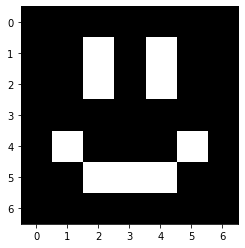

Singular Values with built-in function [5.91074964e+00 1.95402743e+00 8.87936135e-01 6.75562709e-01
 1.47306205e-16 8.50256137e-17 7.47343866e-18]


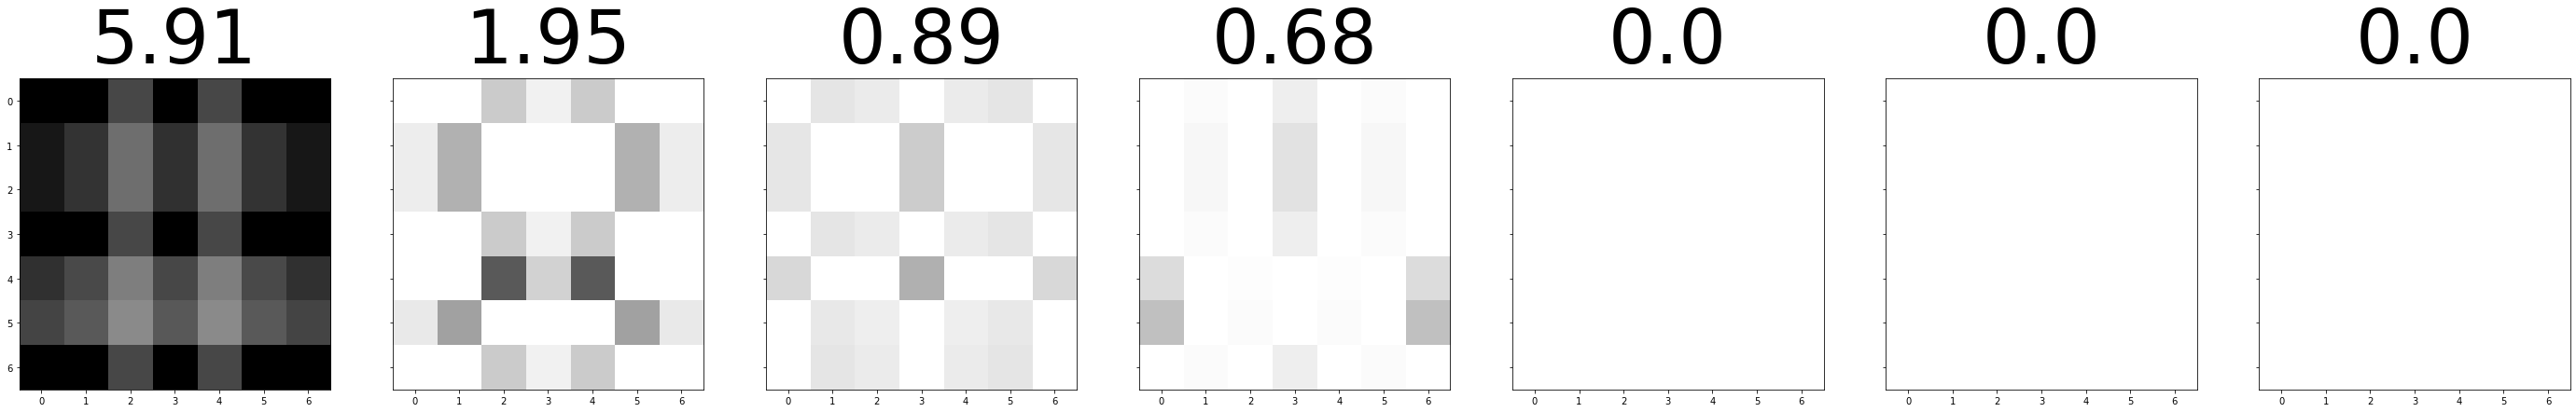

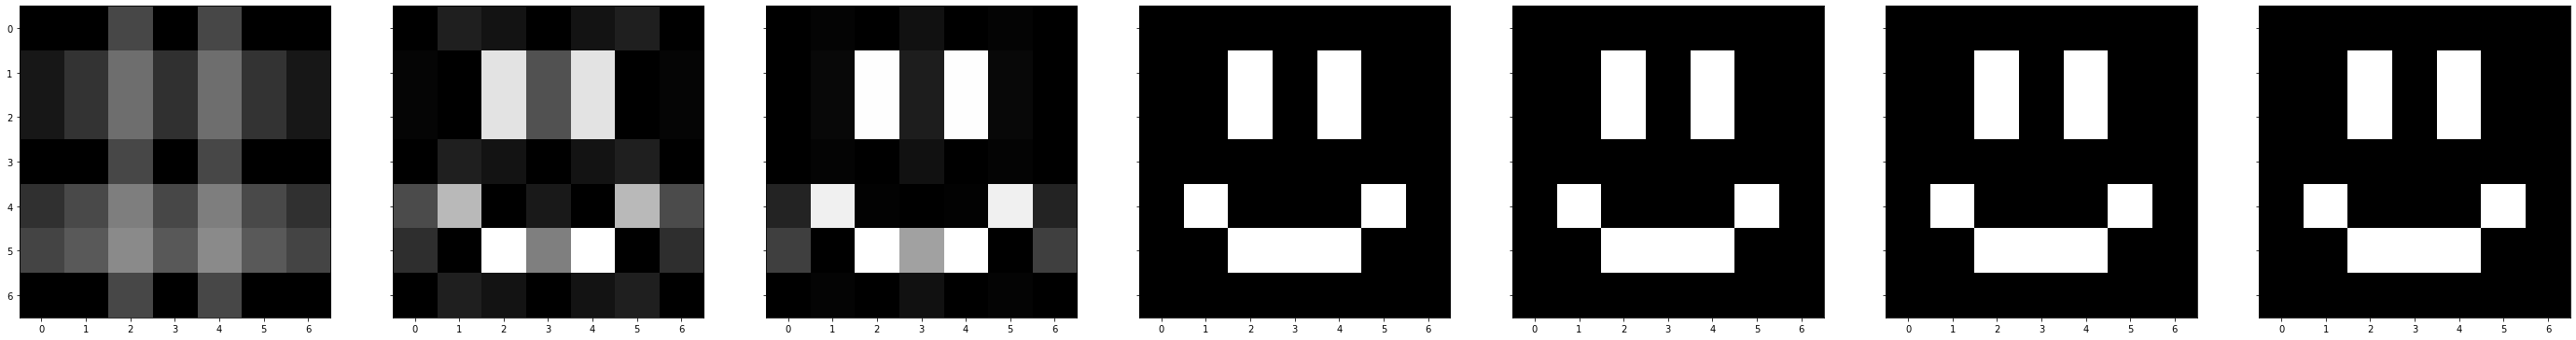

CPU times: user 2.84 s, sys: 216 ms, total: 3.06 s
Wall time: 2.06 s


In [98]:
%%time
D = np.array([[1,1,1,1,1,1,1],
              [1,1,0,1,0,1,1],
              [1,1,0,1,0,1,1],
              [1,1,1,1,1,1,1],
              [1,0,1,1,1,0,1],
              [1,1,0,0,0,1,1],
              [1,1,1,1,1,1,1],
             ],dtype='float64')
U,S,V = plot_svd(D,'built-in')

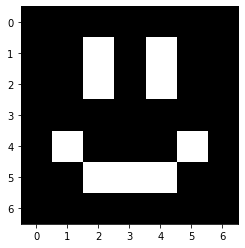

converged in 6 iterations!
converged in 7 iterations!
converged in 17 iterations!
converged in 2 iterations!
Singular Values with manual function [5.91074964 1.95402743 0.88793614 0.67556271]


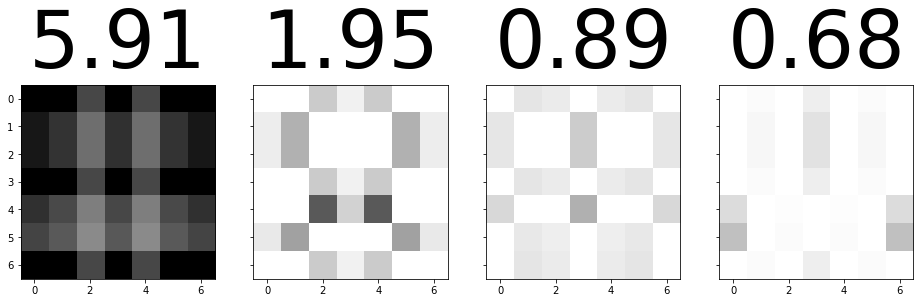

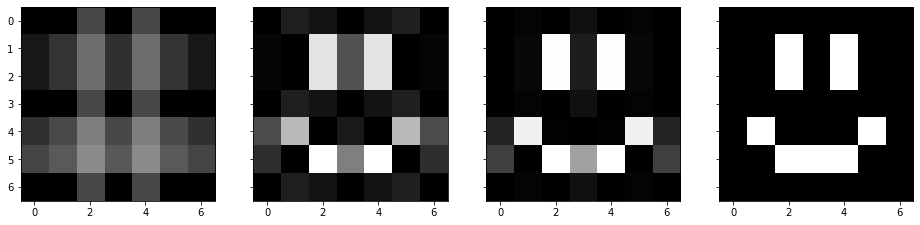

CPU times: user 1.55 s, sys: 154 ms, total: 1.71 s
Wall time: 1.02 s


In [99]:
%%time
D = np.array([[1,1,1,1,1,1,1],
              [1,1,0,1,0,1,1],
              [1,1,0,1,0,1,1],
              [1,1,1,1,1,1,1],
              [1,0,1,1,1,0,1],
              [1,1,0,0,0,1,1],
              [1,1,1,1,1,1,1],
             ],dtype='float64')
U,S,V = plot_svd(D,'manual')

# Reference
1.	[Gentle Introduction to Eigenvalues and Eigenvectors for Machine Learning]( https://machinelearningmastery.com/introduction-to-eigendecomposition-eigenvalues-and-eigenvectors/) 
2.	[Real life examples for eigenvalues / eigenvectors](https://math.stackexchange.com/questions/1520832/real-life-examples-for-eigenvalues-eigenvectors) 
3.	[Eigenvalues and eigenvectors (MIT open courseware)](https://www.youtube.com/watch?v=cdZnhQjJu4I)
4.	[Eigenvalues and eigenvectors (3Blue1Brown)](https://www.youtube.com/watch?v=PFDu9oVAE-g)
5.	[Singular Value Decomposition (SVD) and Image Compression (Luis Serrano)](https://www.youtube.com/watch?v=DG7YTlGnCEo) 
6.	[Master Dimensionality Reduction with these 5 Must-Know Applications of Singular Value Decomposition (SVD) in Data Science (Analytics Vidhya)](https://www.analyticsvidhya.com/blog/2019/08/5-applications-singular-value-decomposition-svd-data-science/) 
7.	[10 Powerful Applications of Linear Algebra in Data Science (with Multiple Resources)](https://www.analyticsvidhya.com/blog/2019/07/10-applications-linear-algebra-data-science/?utm_source=blog&utm_medium=5-applications-singular-value-decomposition-svd-data-science)
8. [SVD in Movie Recommendation System](https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/)
9. [Convert image to Matrix](https://www.youtube.com/watch?v=mAMTXJJQBDI)
10. [Backward and Forward Error Analysis](https://www.math.usm.edu/lambers/mat460/fall09/lecture6.pdf)
11. [Calculate SVD tutorial](https://cs.fit.edu/~dmitra/SciComp/Resources/singular-value-decomposition-fast-track-tutorial.pdf)
12. [SVD theorem proof](https://jeremykun.com/2016/05/16/singular-value-decomposition-part-2-theorem-proof-algorithm/)
13. [Simple SVD](https://towardsdatascience.com/simple-svd-algorithms-13291ad2eef2)
14. [SVD by CMU](https://www.cs.cmu.edu/~venkatg/teaching/CStheory-infoage/book-chapter-4.pdf)
15. [Deep Learning Book Series · 2.8 Singular Value Decomposition - Hadrien Jean Ph.D](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/)
16. [Singular Value Decomposition Part 1 & Part 2- Jeremy Kun](https://jeremykun.com/2016/04/18/singular-value-decomposition-part-1-perspectives-on-linear-algebra/)
